In [1]:
# !pip install numpy
# !pip install matplotlib
# Basic setup: imports and define helper functions
import asyncio, asyncssh, sys, time
import numpy as np
import matplotlib.pyplot as plt

ssh_connections = {}
%store -r

async def start_connection(hostname):
    if hostname not in ssh_connections:
        ssh_connections[hostname] = await asyncssh.connect(hostname, known_hosts=None)
    return ssh_connections[hostname]

async def run_command(hostname, command):
    conn = await start_connection(hostname)
    return (await conn.create_process(command))

async def run_command_sync(hostname, command):
    conn = await start_connection(hostname)
    result = await conn.run(command)
    return result.stdout

async def run_server(hostname):
    return (await run_command(hostname, '/mydata/localuser/frida/server/server'))

async def run_client_throughput(hostname, device_id, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = '/mydata/localuser/frida/experiments/throughput_bench/client {} {} {} {} {}'.format(device_id, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
async def run_multiple_clients_throughput(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/throughput_bench && bash ./run_clients_local.sh {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))

async def run_multiple_clients_latency(num_clients, hostname, device_id_prefix, duration = 10, keepout = 1, datasize = 32, server="http://node0:8080", throughput = 80, asyncOn = True):
    command_str = 'cd /mydata/localuser/frida/experiments/latency_bench && bash ./run_clients_local.sh {} {} {} {} {} {} {}'.format(num_clients, device_id_prefix, duration,keepout,datasize,server, throughput)
    if asyncOn:
        return (await run_command(hostname, command_str))
    else:
        return (await run_command_sync(hostname, command_str))
    
async def clear_server_storage(hostname):
    await run_command_sync(hostname, "rm -r ~/storage")

async def kill_server(hostname):
    await run_command_sync(hostname, "pkill server")
    
def parse_throughput(tstr):
    return float(tstr.split(",")[1])

def parse_latency(tstr):
    res = tstr.split(",")
#     print(res)
    return float(res[1]), float(res[2]), float(res[3])

# Kill everything
async def cleanup(num_nodes):
    for i in range(1, num_nodes + 1):
        await run_command_sync("node{}".format(i), "pkill client")
    await kill_server("node0")
    await clear_server_storage("node0")




In [3]:
await cleanup(10)

In [99]:
await kill_server("node0")
await clear_server_storage("node0")
server_task = await run_server("node0")

In [2]:
async def run_throughput_exp(num_nodes = 2, duration = 20, keepout = 5, data_size = 0, min_cpn = 20, max_cpn = 100, step_size = 5, warmup_period = 5, server_node = "node0"):
    max_clients = max_cpn * num_nodes
    throughputs = [0]
    num_clients_record = [0]
    

    for num_clients_per_node in range(min_cpn, max_cpn + 1, step_size):
        await cleanup(num_nodes)
        time.sleep(10)
        server_task = await run_server(server_node)
        time.sleep(warmup_period)
        ctasks = []
        num_clients = num_nodes * num_clients_per_node
        for node in range(1, num_nodes + 1):
            ctask = await run_multiple_clients_throughput(num_clients_per_node, "node{}".format(node), "exp_C{}_node{}".format(num_clients, node), duration, keepout, data_size, "http://node0:8080")
            ctasks.append(ctask)
        local_throughputs = []
        time.sleep(duration + warmup_period)
        
        curr_node = 0
        for ctask in ctasks:
            curr_node += 1
            coutput = await ctask.stdout.read()
            cerror = await ctask.stderr.read()
            if str(cerror) != "":
                print("Node {}: ".format(curr_node) + str(cerror))
            for line in coutput.split("\n")[:-1]:
                if line != "":
                    local_throughputs.append(parse_throughput(line))
            ctask.terminate()
        num_clients_record.append(num_clients)

        throughput = sum(local_throughputs)
        print("#Nodes={}, #Clients={}, Throughput = {}/s".format(num_nodes, num_clients, throughput))
        throughputs.append(throughput)

    server_task.terminate()
    await clear_server_storage(server_node)
    return num_clients_record, throughputs

In [12]:
async def run_latency_exp_single(num_nodes = 4, duration = 20, keepout = 5, data_size = 0,num_clients_per_node = 20, throughput = 50, warmup_period = 5, server_node = "node0"):
    await cleanup(num_nodes)
    time.sleep(10)
    server_task = await run_server(server_node)
    time.sleep(warmup_period)
    ctasks = []
    num_clients = num_nodes * num_clients_per_node
    for node in range(1, num_nodes + 1):
        ctask = await run_multiple_clients_latency(num_clients_per_node, "node{}".format(node), "exp_C{}_node{}".format(num_clients, node), duration, keepout, data_size, "http://node0:8080", throughput)
        ctasks.append(ctask)
    local_throughputs = []
    local_latencies = []
    local_nmsg = []
    time.sleep(duration + warmup_period)
    curr_node = 0
    for ctask in ctasks:
        curr_node += 1
        coutput = await ctask.stdout.read()
        cerror = await ctask.stderr.read()
        if str(cerror) != "":
            print("Node {}: ".format(curr_node) + str(cerror))
        for line in coutput.split("\n")[:-1]:
            if line != "":
                thrput, lat, nmsg = parse_latency(line)
                local_throughputs.append(thrput)
                local_latencies.append(lat)
                local_nmsg.append(nmsg)
        ctask.terminate()

    throughput = sum(local_throughputs)
    sum_lat = 0.0
    for i in range(len(local_latencies)):
        sum_lat += local_latencies[i] * local_nmsg[i]
    num_msgs = sum(local_nmsg)
    avg_lat = sum_lat / num_msgs
    print("#Nodes={}, #Clients={}, Throughput = {}, Latency = {}ms, #Received = {}".format(num_nodes, num_clients, throughput, avg_lat, num_msgs))
    return avg_lats, throughput


async def run_latency_exp(num_nodes = 10, duration = 20, keepout = 5, data_size = 0, num_clients_per_node = 20, min_tpc = 5, max_tpc = 80, step_size=5, warmup_period = 5, server_node = "node0"):
    throughputs = []
    latencies = []
#     num_clients_record = [0]
    
    for throughput in range(min_tpc, max_tpc + 1, step_size):
        avg_lats, throughput = run_latency_exp_single(num_nodes, duration, keepout, data_size, num_clients_per_node, throughput, warmup_period, server_node)
        throughputs.append(throughput)
        latencies.append(avg_lat)

    server_task.terminate()
    await clear_server_storage(server_node)
    return throughputs, latencies


In [5]:
def co_sort(arr1, arr2, on="first"):
    combined = [(arr1[i], arr2[i]) for i in range(len(arr1))]
    combined.sort(key=(lambda x:x[0]) if on=="first" else (lambda x:x[1]))
    return [e[0] for e in combined],[e[1] for e in combined]

In [11]:
throughputs_clienttest, latencies_clienttest = await run_latency_exp(num_nodes=4, duration = 30, keepout = 5, num_clients_per_node=10, min_tpc = 100, max_tpc = 100, step_size = 10,warmup_period = 3)
%store throughputs_clienttest
%store latencies_clienttest

#Nodes=4, #Clients=40, Throughput = 3171.05, Latency = 11.930267341155954ms, #Received = 63065.0
Stored 'throughputs_clienttest' (list)
Stored 'latencies_clienttest' (list)


In [6]:
throughputs_N10C20_nagle, latencies_N10C20_nagle = await run_latency_exp(num_nodes=10, duration = 30, keepout = 5, num_clients_per_node=20, min_tpc = 10, max_tpc = 150, step_size = 10,warmup_period = 3)
%store throughputs_N10C20_nagle
%store latencies_N10C20_nagle

#Nodes=10, #Clients=200, Throughput = 2000.0, Latency = 10.846973072499996ms, #Received = 40000.0
#Nodes=10, #Clients=200, Throughput = 4000.0, Latency = 10.379289692499993ms, #Received = 80000.0
#Nodes=10, #Clients=200, Throughput = 6001.050000000004, Latency = 8.083233229927483ms, #Received = 119970.0
#Nodes=10, #Clients=200, Throughput = 7981.699999999998, Latency = 7.468120280563782ms, #Received = 159635.0
#Nodes=10, #Clients=200, Throughput = 9902.399999999998, Latency = 7.210203610223234ms, #Received = 198000.0
#Nodes=10, #Clients=200, Throughput = 11822.3, Latency = 7.422010024896153ms, #Received = 236406.0
#Nodes=10, #Clients=200, Throughput = 13721.700000000006, Latency = 7.886244272805228ms, #Received = 274391.0
#Nodes=10, #Clients=200, Throughput = 15353.199999999999, Latency = 8.840769764482408ms, #Received = 307045.0
#Nodes=10, #Clients=200, Throughput = 16500.250000000004, Latency = 10.048799489492847ms, #Received = 329918.0
#Nodes=10, #Clients=200, Throughput = 17069.4, 

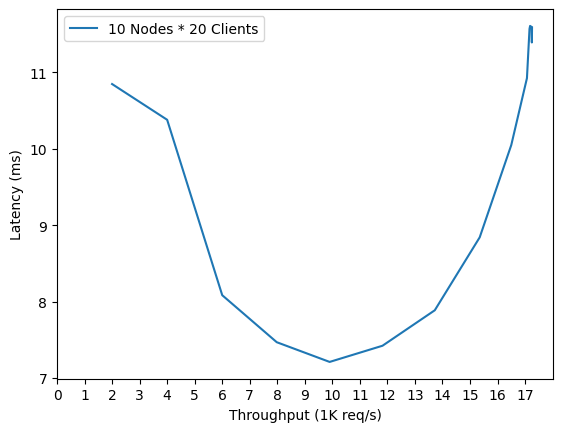

In [9]:
throughputs_sorted, latencies_sorted = co_sort(throughputs_N10C20_nagle, latencies_N10C20_nagle)
plt.plot(np.array(throughputs_sorted)/1000, latencies_sorted, label="10 Nodes * 20 Clients")
# plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(0, 18, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [39]:
throughputs_N10C20, latencies_N10C20 = await run_latency_exp(num_nodes=10, duration = 30, keepout = 5, num_clients_per_node=20, min_tpc = 20, max_tpc = 150, step_size = 10,warmup_period = 3)
%store throughputs_N10C20
%store latencies_N10C20

#Nodes=10, #Clients=200, Throughput = 4000.0, Latency = 9.443216324999996ms, #Received = 80000.0
#Nodes=10, #Clients=200, Throughput = 5987.350000000004, Latency = 8.115980021537114ms, #Received = 119705.0
#Nodes=10, #Clients=200, Throughput = 7940.8499999999985, Latency = 7.612311629530287ms, #Received = 158820.0
#Nodes=10, #Clients=200, Throughput = 9872.149999999987, Latency = 7.414702768339033ms, #Received = 197445.0
#Nodes=10, #Clients=200, Throughput = 11845.699999999999, Latency = 7.436674512515411ms, #Received = 236844.0
#Nodes=10, #Clients=200, Throughput = 13675.099999999999, Latency = 7.947576716850788ms, #Received = 273459.0
#Nodes=10, #Clients=200, Throughput = 15383.549999999994, Latency = 8.848720324208983ms, #Received = 307675.0
#Nodes=10, #Clients=200, Throughput = 16354.100000000004, Latency = 10.254407451354135ms, #Received = 326852.0
#Nodes=10, #Clients=200, Throughput = 16933.000000000007, Latency = 10.980319437351907ms, #Received = 338454.0
#Nodes=10, #Clients=200

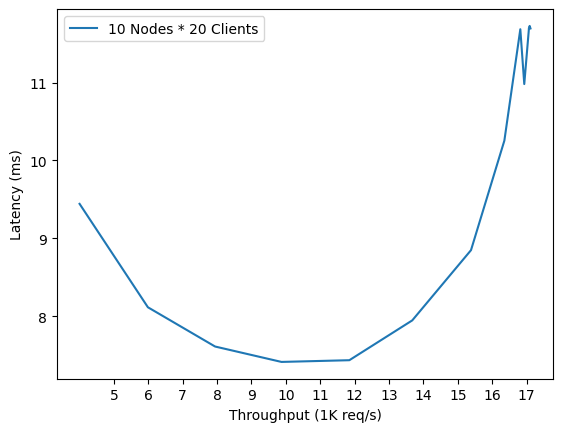

In [40]:
throughputs_sorted, latencies_sorted = co_sort(throughputs_N10C20, latencies_N10C20)
plt.plot(np.array(throughputs_sorted)/1000, latencies_sorted, label="10 Nodes * 20 Clients")
# plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(5, 18, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [94]:
throughputs_N4C50, latencies_N4C50 = await run_latency_exp(num_nodes=4, duration = 70, keepout = 5, num_clients_per_node=50, min_tpc = 50, max_tpc = 120, step_size = 1,warmup_period = 5)
%store throughputs_N4C50
%store latencies_N4C50

#Nodes=4, #Clients=200, Throughput = 9929.849926, Latency = 6.55348247578822ms, #Received = 595772.0
#Nodes=4, #Clients=200, Throughput = 10130.449926000007, Latency = 6.551255065361782ms, #Received = 607768.0
#Nodes=4, #Clients=200, Throughput = 10320.999946000004, Latency = 6.645147829029636ms, #Received = 619219.0
#Nodes=4, #Clients=200, Throughput = 10528.566588, Latency = 6.6459678667126365ms, #Received = 631630.0
#Nodes=4, #Clients=200, Throughput = 10716.999949999998, Latency = 6.82693447076582ms, #Received = 642970.0
#Nodes=4, #Clients=200, Throughput = 10911.799976999995, Latency = 6.794660581155645ms, #Received = 654668.0
#Nodes=4, #Clients=200, Throughput = 11093.833393999992, Latency = 6.887893650869181ms, #Received = 665509.0
#Nodes=4, #Clients=200, Throughput = 11316.299947999996, Latency = 6.822681599837684ms, #Received = 678933.0
#Nodes=4, #Clients=200, Throughput = 11466.016593, Latency = 6.9650033906965385ms, #Received = 687905.0
#Nodes=4, #Clients=200, Throughput = 1

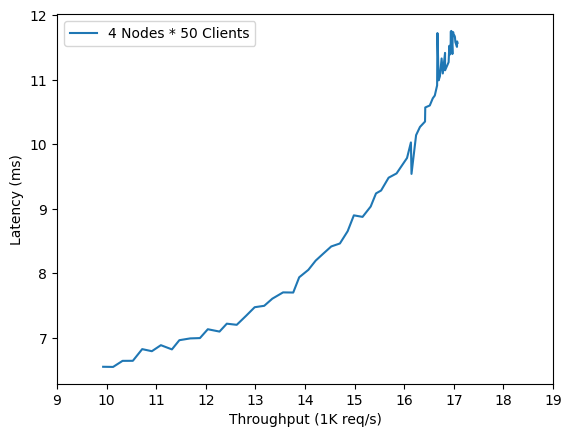

In [96]:
throughputs_sorted, latencies_sorted = co_sort(throughputs_N4C50, latencies_N4C50)
plt.plot(np.array(throughputs_sorted)/1000, latencies_sorted, label="4 Nodes * 50 Clients")
# plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(9, 20, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [83]:
throughputs_N4C25, latencies_N4C25 = await run_latency_exp(num_nodes=4, duration = 30, keepout = 5, num_clients_per_node=25, min_tpc = 80, max_tpc = 200, step_size = 10,warmup_period = 3)
%store throughputs_N4C25
%store latencies_N4C25

Stored 'throughputs_N4C25' (list)
Stored 'latencies_N4C25' (list)


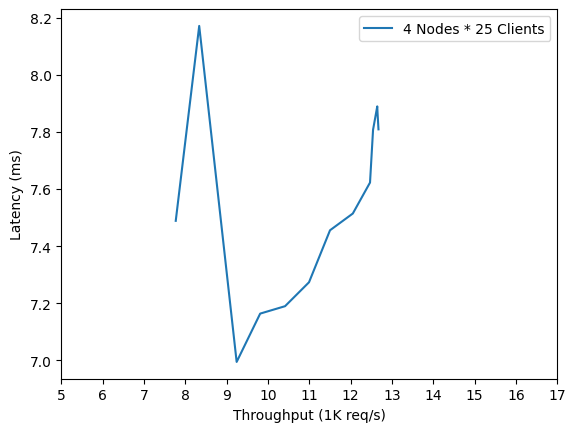

In [85]:
throughputs_sorted, latencies_sorted = co_sort(throughputs_N4C25, latencies_N4C25)
plt.plot(np.array(throughputs_sorted)/1000, latencies_sorted, label="4 Nodes * 25 Clients")
# plt.plot(num_clients, throughputs, label="22")
plt.xticks(np.arange(5, 18, step = 1))
plt.xlabel("Throughput (1K req/s)")
plt.ylabel("Latency (ms)")
plt.legend()
plt.show()

In [68]:
num_clients_n1, throughputs_n1 = await run_throughput_exp(num_nodes = 1, min_cpn = 8, max_cpn = 200, step_size=8)
%store num_clients_n1
%store throughputs_n1

num_clients_n2, throughputs_n2 = await run_throughput_exp(num_nodes = 2, min_cpn = 4, max_cpn = 100, step_size=4)
%store num_clients_n2
%store throughputs_n2

num_clients_n4, throughputs_n4 = await run_throughput_exp(num_nodes = 4, min_cpn = 2, max_cpn = 50, step_size=2)
%store num_clients_n4
%store throughputs_n4

num_clients_n8, throughputs_n8 = await run_throughput_exp(num_nodes = 8, min_cpn = 1, max_cpn = 25, step_size=1)
%store num_clients_n8
%store throughputs_n8

#Nodes=1, #Clients=8, Throughput = 632.1/s
#Nodes=1, #Clients=16, Throughput = 1260.8/s
#Nodes=1, #Clients=24, Throughput = 1882.4/s
#Nodes=1, #Clients=32, Throughput = 2486.4999999999995/s
#Nodes=1, #Clients=40, Throughput = 2817.8000000000006/s
#Nodes=1, #Clients=48, Throughput = 3475.5999999999995/s
#Nodes=1, #Clients=56, Throughput = 4090.5000000000005/s
#Nodes=1, #Clients=64, Throughput = 4891.300000000001/s
#Nodes=1, #Clients=72, Throughput = 5322.199999999999/s
#Nodes=1, #Clients=80, Throughput = 5728.900000000001/s
#Nodes=1, #Clients=88, Throughput = 6050.3/s
#Nodes=1, #Clients=96, Throughput = 5764.599999999997/s
#Nodes=1, #Clients=104, Throughput = 7717.499999999999/s
#Nodes=1, #Clients=112, Throughput = 7882.799999999997/s
#Nodes=1, #Clients=120, Throughput = 8359.3/s
#Nodes=1, #Clients=128, Throughput = 10371.999999999996/s
#Nodes=1, #Clients=136, Throughput = 10606.100000000002/s
#Nodes=1, #Clients=144, Throughput = 11128.300000000005/s
#Nodes=1, #Clients=152, Throughput =

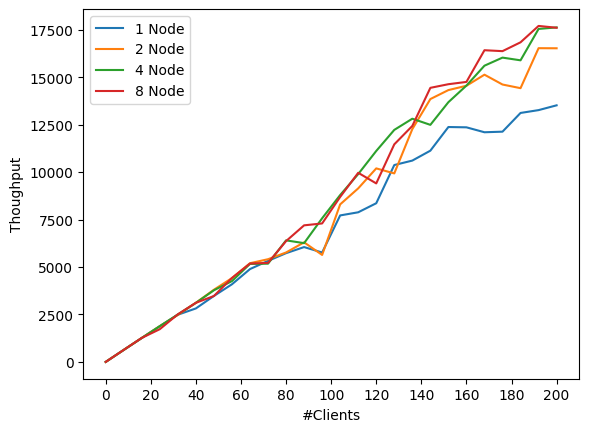

In [70]:
plt.plot(num_clients_n1, throughputs_n1, label="1 Node")
plt.plot(num_clients_n2, throughputs_n2, label="2 Node")
plt.plot(num_clients_n4, throughputs_n4, label="4 Node")
plt.plot(num_clients_n8, throughputs_n8, label="8 Node")
plt.xticks(np.arange(0, 201, step = 20))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.legend()
plt.show()

In [71]:
num_clients_n4_fine, throughputs_n4_fine = await run_throughput_exp(num_nodes = 4, duration = 70, keepout = 5, min_cpn = 2, max_cpn = 75, step_size=1)
%store num_clients_n4_fine
%store throughputs_n4_fine

#Nodes=4, #Clients=8, Throughput = 629.5666759999999/s
#Nodes=4, #Clients=12, Throughput = 957.0666699999999/s
#Nodes=4, #Clients=16, Throughput = 1301.0499919999997/s
#Nodes=4, #Clients=20, Throughput = 1663.9333380000005/s
#Nodes=4, #Clients=24, Throughput = 2208.033332/s
#Nodes=4, #Clients=28, Throughput = 3118.4500039999994/s
#Nodes=4, #Clients=32, Throughput = 3959.033326/s
#Nodes=4, #Clients=36, Throughput = 4921.76669/s
#Nodes=4, #Clients=40, Throughput = 5772.06669/s
#Nodes=4, #Clients=44, Throughput = 6637.9833499999995/s
#Nodes=4, #Clients=48, Throughput = 7422.46667/s
#Nodes=4, #Clients=52, Throughput = 8254.93332/s
#Nodes=4, #Clients=56, Throughput = 8669.966713999997/s
#Nodes=4, #Clients=60, Throughput = 8868.400016/s
#Nodes=4, #Clients=64, Throughput = 10471.400049999997/s
#Nodes=4, #Clients=68, Throughput = 10807.033319999997/s
#Nodes=4, #Clients=72, Throughput = 10613.9333/s
#Nodes=4, #Clients=76, Throughput = 11059.700009999999/s
#Nodes=4, #Clients=80, Throughput = 127

In [75]:
num_clients_n4_fine_more, throughputs_n4_fine_more = await run_throughput_exp(num_nodes = 4, duration = 70, keepout = 5, min_cpn = 76, max_cpn = 100, step_size=1)
%store num_clients_n4_fine_more
%store throughputs_n4_fine_more

#Nodes=4, #Clients=304, Throughput = 20188.416734999995/s
#Nodes=4, #Clients=308, Throughput = 19747.066698000006/s
#Nodes=4, #Clients=312, Throughput = 19770.866679/s
#Nodes=4, #Clients=316, Throughput = 20207.166733000005/s
#Nodes=4, #Clients=320, Throughput = 20133.06671500001/s
#Nodes=4, #Clients=324, Throughput = 20057.06670900001/s
#Nodes=4, #Clients=328, Throughput = 20111.36669099999/s
#Nodes=4, #Clients=332, Throughput = 20188.099970999992/s
#Nodes=4, #Clients=336, Throughput = 20286.166648000002/s
#Nodes=4, #Clients=340, Throughput = 20177.583347/s
#Nodes=4, #Clients=344, Throughput = 20284.216634999997/s
#Nodes=4, #Clients=348, Throughput = 20273.633345999977/s
#Nodes=4, #Clients=352, Throughput = 20227.616643999994/s
#Nodes=4, #Clients=356, Throughput = 20350.41669200001/s
#Nodes=4, #Clients=360, Throughput = 20306.833334/s
#Nodes=4, #Clients=364, Throughput = 20204.516652000002/s
#Nodes=4, #Clients=368, Throughput = 20248.749990000004/s
#Nodes=4, #Clients=372, Throughput =

In [80]:
num_clients_n4_fine_final = num_clients_n4_fine + num_clients_n4_fine_more[1:]
throughputs_n4_fine_final = throughputs_n4_fine + throughputs_n4_fine_more[1:]
%store num_clients_n4_fine_final
%store throughputs_n4_fine_final

Stored 'num_clients_n4_fine_final' (list)
Stored 'throughputs_n4_fine_final' (list)


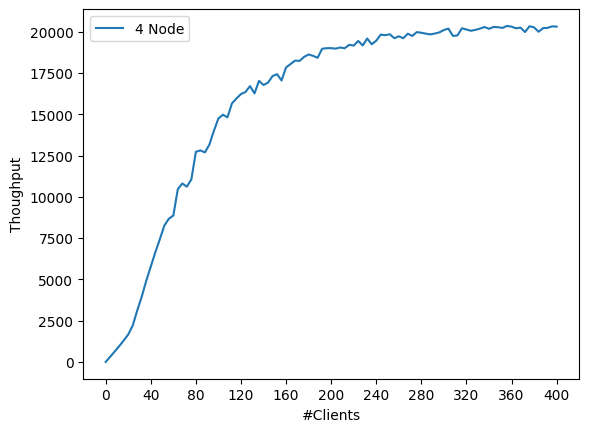

In [81]:
plt.plot(num_clients_n4_fine_final, throughputs_n4_fine_final, label="4 Node")
plt.xticks(np.arange(0, 401, step = 40))
plt.xlabel("#Clients")
plt.ylabel("Thoughput")
plt.legend()
plt.show()